<a href="https://colab.research.google.com/github/olegnovitskij/HSE-data-analyst-test-assignment/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22%5Bhomework%5Ddense_and_convolutional_nn_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Полносвязные и свёрточные нейронные сети</b></h3>

В этом занятии вам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.








In [1]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [20]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

In [21]:
X = X.astype(np.float32)
y = y.astype(np.float32)

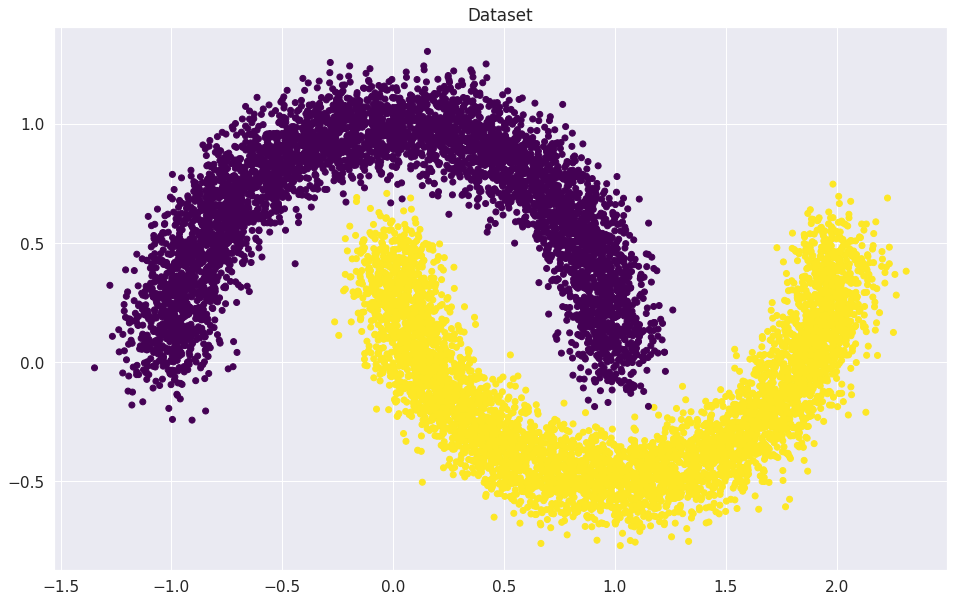

In [24]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [257]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [258]:
X_train_t =  torch.tensor(X_train, dtype=torch.float32)# YOUR CODE GOES HERE
y_train_t =  torch.tensor(y_train, dtype=torch.float32)# YOUR CODE GOES HERE
X_val_t =  torch.tensor(X_val, dtype=torch.float32)# YOUR CODE GOES HERE
y_val_t =  torch.tensor(y_val, dtype=torch.float32)# YOUR CODE GOES HERE

Создаем `Dataset` и `DataLoader`. 

In [259]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут 
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [266]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn((in_features, out_features)))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn((1, out_features)))# YOUR CODE GOES HERE

    def forward(self, x):
        x =  x @ self.weights # YOUR CODE GOES HERE
        if self.bias:
            x += self.bias_term # YOUR CODE GOES HERE
        return x

In [267]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [268]:
linear_regression = LinearRegression(2, 1).to(device)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели?

In [263]:
#YOUR CODE
sum(p.numel() for p in linear_regression.parameters())


3

### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание. Реализация цикла обучения

In [269]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp =  linear_regression(X_batch.to(device))# YOUR CODE. Use linear_regression to get output
        loss =  loss_function(outp.flatten().to(device), y_batch.to(device))# YOUR CODE. Compute loss
        loss.backward()
        losses.append(loss.detach().flatten()[0].cpu())
        optimizer.step()
        probabilities = torch.sigmoid(X_batch.to(device)).detach()# YOUR CODE. Compute probabilities
        preds = (probabilities > 0.5).type(torch.long)[:, 0]
        batch_acc = (preds.flatten() == y_batch.to(device)).type(torch.float32).sum() / y_batch.size(0)
        
        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.6875
Iteration: 100
Batch accuracy: 0.7265625
Iteration: 200
Batch accuracy: 0.7265625
Iteration: 300
Batch accuracy: 0.796875
Iteration: 400
Batch accuracy: 0.71875
Iteration: 500
Batch accuracy: 0.734375

Iteration: 578.Convergence. Stopping iterations.


**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:**
300

### Визуализируем результаты

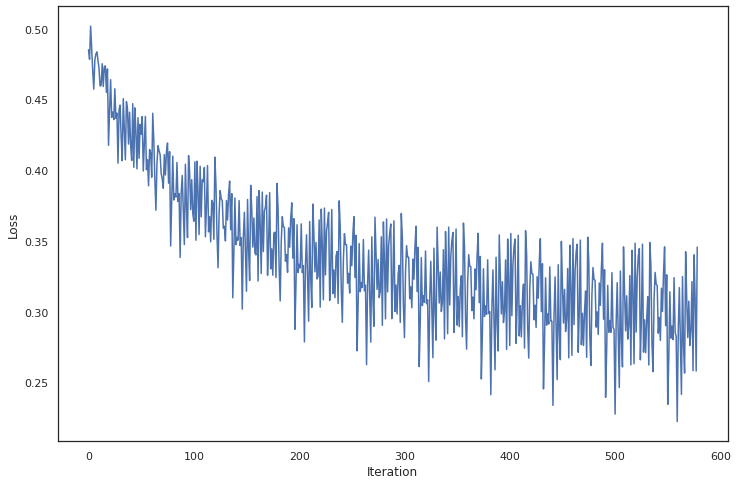

In [270]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

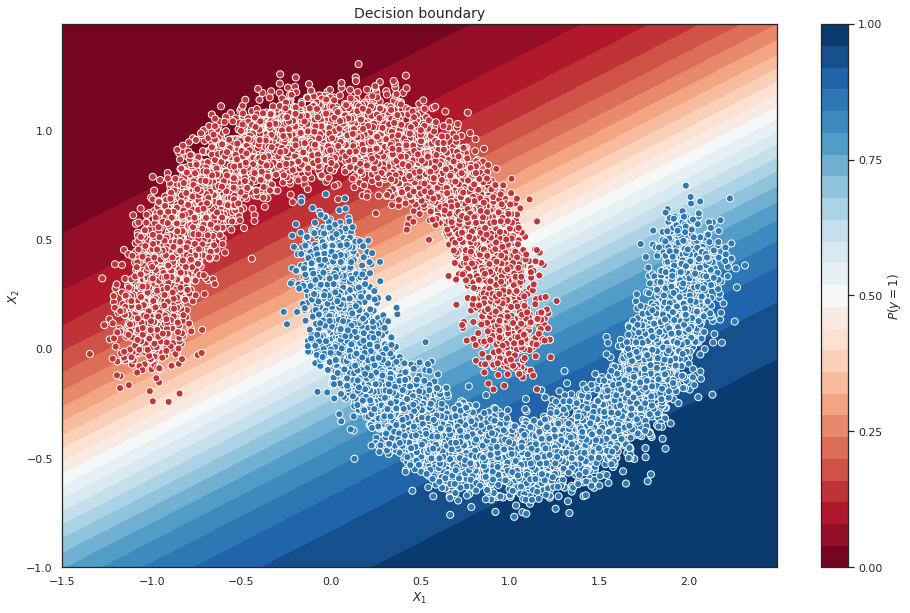

In [271]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression.cpu()(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [77]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:   
        preds = model(x_batch.to(device))#YOUR CODE. Compute predictions
        predictions = np.hstack((predictions, preds.cpu().numpy().flatten()))
    return predictions.flatten()

In [83]:
from sklearn.metrics import accuracy_score

# YOUR CODE. Compute total accuracy
accuracy_score(predict(val_dataloader, linear_regression) > 0.5, y_val)

0.8592

**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:** 
0.8592


# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [85]:
import os
from torchvision.datasets import MNIST
import torchvision.transforms as tfs

data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader =  DataLoader(train_dataset, batch_size=128) # YOUR CODE GOES HERE
valid_dataloader =  DataLoader(val_dataset, batch_size=128)# YOUR CODE GOES HERE

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [87]:
print(len(train_dataset))

60000


In [88]:
print(len(val_dataset))

10000


In [99]:
np.array(next(iter(train_dataloader))[0][0]).size

784

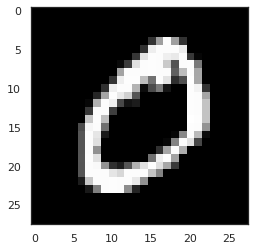

In [106]:
plt.imshow(train_dataloader.dataset.train_data[1].numpy(), cmap='gray')

In [108]:
train_dataloader.dataset.train_data.shape

torch.Size([60000, 28, 28])

## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [89]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Задание. Простая полносвязная нейронная сеть 

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [109]:
activation = nn.ELU

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 128),
    activation(),
    nn.Linear(128, 128),
    activation(),
    nn.Linear(128, 10)
    #YOUR CODE. Add layers to your sequential class
)

In [110]:
criterion = nn.CrossEntropyLoss()#YOUR CODE. Select a loss function
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [111]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Задание. Дополните цикл обучения.

In [116]:
y_batch.size()

torch.Size([128])

In [120]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                model.train().to(device)
                optimizer.zero_grad()
                outp = model(x_batch.to(device))
                 # YOUR CODE. Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
            else:
                model.eval()
                with torch.no_grad():
                    outp = model.to(device)(x_batch.to(device))
                 # YOUR CODE. Set model to ``eval`` mode and calculate outputs
            preds = outp.argmax(-1)
            correct = (preds == y_batch.to(device)).sum()# YOUR CODE GOES HERE
            all = y_batch.size()[0]# YOUR CODE GOES HERE
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch.to(device))
                loss.backward()
                optimizer.step()
                # YOUR CODE. Calculate gradients and make a step of your optimizer
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


Epoch: 1
Loader: train. Accuracy: 0.8812833333333333
Loader: valid. Accuracy: 0.925
Epoch: 2
Loader: train. Accuracy: 0.94155
Loader: valid. Accuracy: 0.9515
Epoch: 3
Loader: train. Accuracy: 0.9582833333333334
Loader: valid. Accuracy: 0.9596
Epoch: 4
Loader: train. Accuracy: 0.9674
Loader: valid. Accuracy: 0.9632
Epoch: 5
Loader: train. Accuracy: 0.9737833333333333
Loader: valid. Accuracy: 0.9685
Epoch: 6
Loader: train. Accuracy: 0.9788666666666667
Loader: valid. Accuracy: 0.9714
Epoch: 7
Loader: train. Accuracy: 0.98205
Loader: valid. Accuracy: 0.9727
Epoch: 8
Loader: train. Accuracy: 0.9846
Loader: valid. Accuracy: 0.9732
Epoch: 9
Loader: train. Accuracy: 0.9864666666666667
Loader: valid. Accuracy: 0.9668
Epoch: 10
Loader: train. Accuracy: 0.98695
Loader: valid. Accuracy: 0.9658


### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [121]:
elu_accuracy = accuracy["valid"]

In [158]:
# YOUR CODE. Do the same thing with other activations (it's better to wrap into a function that returns a list of accuracies)

def test_activation_function(activation, max_epochs=10):
    model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 128),
    activation(),
    nn.Linear(128, 128),
    activation(),
    nn.Linear(128, 10)
    #YOUR CODE. Add layers to your sequential class
    )
    criterion = nn.CrossEntropyLoss()#YOUR CODE. Select a loss function
    optimizer = torch.optim.Adam(model.parameters())
    loaders = {"train": train_dataloader, "valid": valid_dataloader}
    accuracy = {"train": [], "valid": []}
    for epoch in range(max_epochs):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            for x_batch, y_batch in dataloader:
                if k == "train":
                    model.train().to(device)
                    optimizer.zero_grad()
                    outp = model(x_batch.to(device))
                    # YOUR CODE. Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
                else:
                    model.eval()
                    with torch.no_grad():
                        outp = model.to(device)(x_batch.to(device))
                    # YOUR CODE. Set model to ``eval`` mode and calculate outputs
                preds = outp.argmax(-1)
                correct = (preds == y_batch.to(device)).sum()# YOUR CODE GOES HERE
                all = y_batch.size()[0]# YOUR CODE GOES HERE
                epoch_correct += correct.item()
                epoch_all += all
                if k == "train":
                    loss = criterion(outp, y_batch.to(device))
                    loss.backward()
                    optimizer.step()
                    # YOUR CODE. Calculate gradients and make a step of your optimizer
            if k == "train":
                print(f"Epoch: {epoch+1}")
            print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
            accuracy[k].append(epoch_correct/epoch_all)

    return accuracy["valid"]

In [141]:
elu_accuracy = test_activation_function(nn.ELU)
plain_accuracy = test_activation_function(Identical)
relu_accuracy = test_activation_function(nn.ReLU)
leaky_relu_accuracy = test_activation_function(nn.Mish)
check_identity_accuracy = test_activation_function(nn.Identity)
celu_accuracy = test_activation_function(nn.CELU)
selu_accuracy = test_activation_function(nn.SELU)
gelu_accuracy = test_activation_function(nn.GELU)
softplus_accuracy = test_activation_function(nn.Softplus)
logsigmoid_accuracy = test_activation_function(nn.LogSigmoid)
tanhshrink_accuracy = test_activation_function(nn.Tanhshrink)

Epoch: 1
Loader: train. Accuracy: 0.8809833333333333
Loader: valid. Accuracy: 0.9299
Epoch: 2
Loader: train. Accuracy: 0.9433166666666667
Loader: valid. Accuracy: 0.9529
Epoch: 3
Loader: train. Accuracy: 0.9596
Loader: valid. Accuracy: 0.9612
Epoch: 4
Loader: train. Accuracy: 0.9678166666666667
Loader: valid. Accuracy: 0.963
Epoch: 5
Loader: train. Accuracy: 0.9739166666666667
Loader: valid. Accuracy: 0.962
Epoch: 6
Loader: train. Accuracy: 0.9783166666666666
Loader: valid. Accuracy: 0.965
Epoch: 7
Loader: train. Accuracy: 0.982
Loader: valid. Accuracy: 0.9678
Epoch: 8
Loader: train. Accuracy: 0.98355
Loader: valid. Accuracy: 0.9712
Epoch: 9
Loader: train. Accuracy: 0.9850166666666667
Loader: valid. Accuracy: 0.9695
Epoch: 10
Loader: train. Accuracy: 0.9860166666666667
Loader: valid. Accuracy: 0.9706
Epoch: 1
Loader: train. Accuracy: 0.86445
Loader: valid. Accuracy: 0.8846
Epoch: 2
Loader: train. Accuracy: 0.8957
Loader: valid. Accuracy: 0.902
Epoch: 3
Loader: train. Accuracy: 0.900033

In [144]:
elu_accuracy[-1]

0.9706

In [145]:
plain_accuracy[-1]

0.9039

In [146]:
relu_accuracy[-1]

0.848

In [147]:
leaky_relu_accuracy[-1]

0.9646

In [148]:
check_identity_accuracy[-1]

0.9031

In [150]:
celu_accuracy[-1]

0.9714

In [151]:
selu_accuracy[-1]

0.9733

In [152]:
gelu_accuracy[-1]

0.9643

In [153]:
softplus_accuracy[-1]

0.974

In [154]:
logsigmoid_accuracy[-1]

0.9656

In [155]:
tanhshrink_accuracy[-1]

0.9609

In [156]:
# best -> softplus!

In [157]:
softplus_accuracy

[0.915, 0.9432, 0.9578, 0.9628, 0.966, 0.9684, 0.97, 0.9711, 0.9718, 0.974]

In [159]:
softplus_100_accuracy = test_activation_function(nn.Softplus, max_epochs=100)

Epoch: 1
Loader: train. Accuracy: 0.8577666666666667
Loader: valid. Accuracy: 0.9204
Epoch: 2
Loader: train. Accuracy: 0.9269333333333334
Loader: valid. Accuracy: 0.9426
Epoch: 3
Loader: train. Accuracy: 0.94685
Loader: valid. Accuracy: 0.9543
Epoch: 4
Loader: train. Accuracy: 0.9578833333333333
Loader: valid. Accuracy: 0.9605
Epoch: 5
Loader: train. Accuracy: 0.9665166666666667
Loader: valid. Accuracy: 0.9621
Epoch: 6
Loader: train. Accuracy: 0.9719666666666666
Loader: valid. Accuracy: 0.964
Epoch: 7
Loader: train. Accuracy: 0.97595
Loader: valid. Accuracy: 0.9643
Epoch: 8
Loader: train. Accuracy: 0.9794
Loader: valid. Accuracy: 0.9669
Epoch: 9
Loader: train. Accuracy: 0.9821166666666666
Loader: valid. Accuracy: 0.9699
Epoch: 10
Loader: train. Accuracy: 0.9845
Loader: valid. Accuracy: 0.9721
Epoch: 11
Loader: train. Accuracy: 0.9867166666666667
Loader: valid. Accuracy: 0.9708
Epoch: 12
Loader: train. Accuracy: 0.9881333333333333
Loader: valid. Accuracy: 0.9712
Epoch: 13
Loader: train.

### Accuracy
Построим график accuracy/epoch для каждой функции активации.

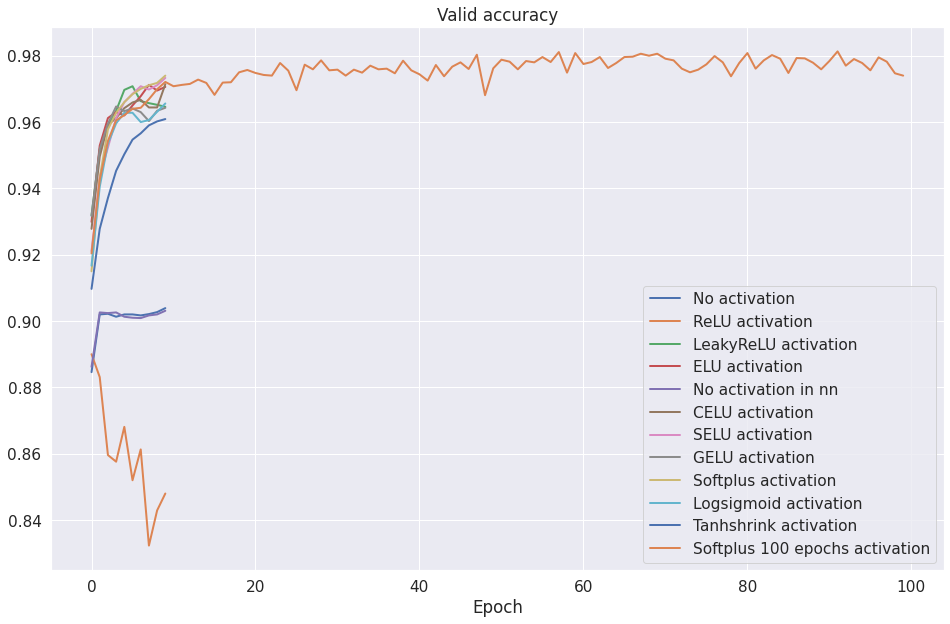

In [160]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), check_identity_accuracy, label="No activation in nn", linewidth=2)
plt.plot(range(max_epochs), celu_accuracy, label="CELU activation", linewidth=2)
plt.plot(range(max_epochs), selu_accuracy, label="SELU activation", linewidth=2)
plt.plot(range(max_epochs), gelu_accuracy, label="GELU activation", linewidth=2)
plt.plot(range(max_epochs), softplus_accuracy, label="Softplus activation", linewidth=2)
plt.plot(range(max_epochs), logsigmoid_accuracy, label="Logsigmoid activation", linewidth=2)
plt.plot(range(max_epochs), tanhshrink_accuracy, label="Tanhshrink activation", linewidth=2)
plt.plot(range(100), softplus_100_accuracy, label="Softplus 100 epochs activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:** softplus 

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [162]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2022-09-17 22:14:42--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village.kz (img.the-village.kz)... 144.76.208.75
Connecting to img.the-village.kz (img.the-village.kz)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg [following]
--2022-09-17 22:14:43--  https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village-kz.com (img.the-village-kz.com)... 144.76.208.75
Connecting to img.the-village-kz.com (img.the-village-kz.com)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49337 (48K) [image/jpeg]
Saving to: ‘sample_photo.jpg’

sample_photo.jpg    100%[===================>]  48.18K   165KB/s    in 0.3s    

2022-09-17 22:14:44 (165 KB/s) - ‘sample_photo.jpg’ saved [49337/4

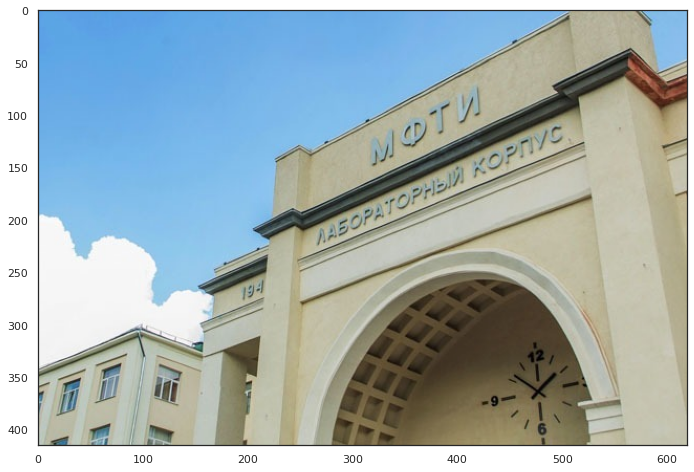

In [163]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте 
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [187]:
kernels = \
{'zero': [
    [0, 0, 0],
    [1, -2, 1],
    [0, 0, 0]
],
 'a':[
    [0, 0, 0],
    [0, 1, 0],
    [0, 0, 0]
],
 'b':[
    [0, 1, 0],
    [0, -2, 0],
    [0, 1, 0]
],
 'v':[
    [0, 0, 0],
    [1, -2, 1],
    [0, 0, 0]
],
 'g':[
    [0, 1, 0],
    [1, -4, 1],
    [0, 1, 0]
],
 'd':[
    [0, -1, 0],
    [-1, 5, -1],
    [0, -1, 0]
],
 'e':[
    [0.0625, 0.125, 0.0625],
    [0.125, 0.25, 0.125],
    [0.0625, 0.125, 0.0625]
]
}

In [188]:
result = {}

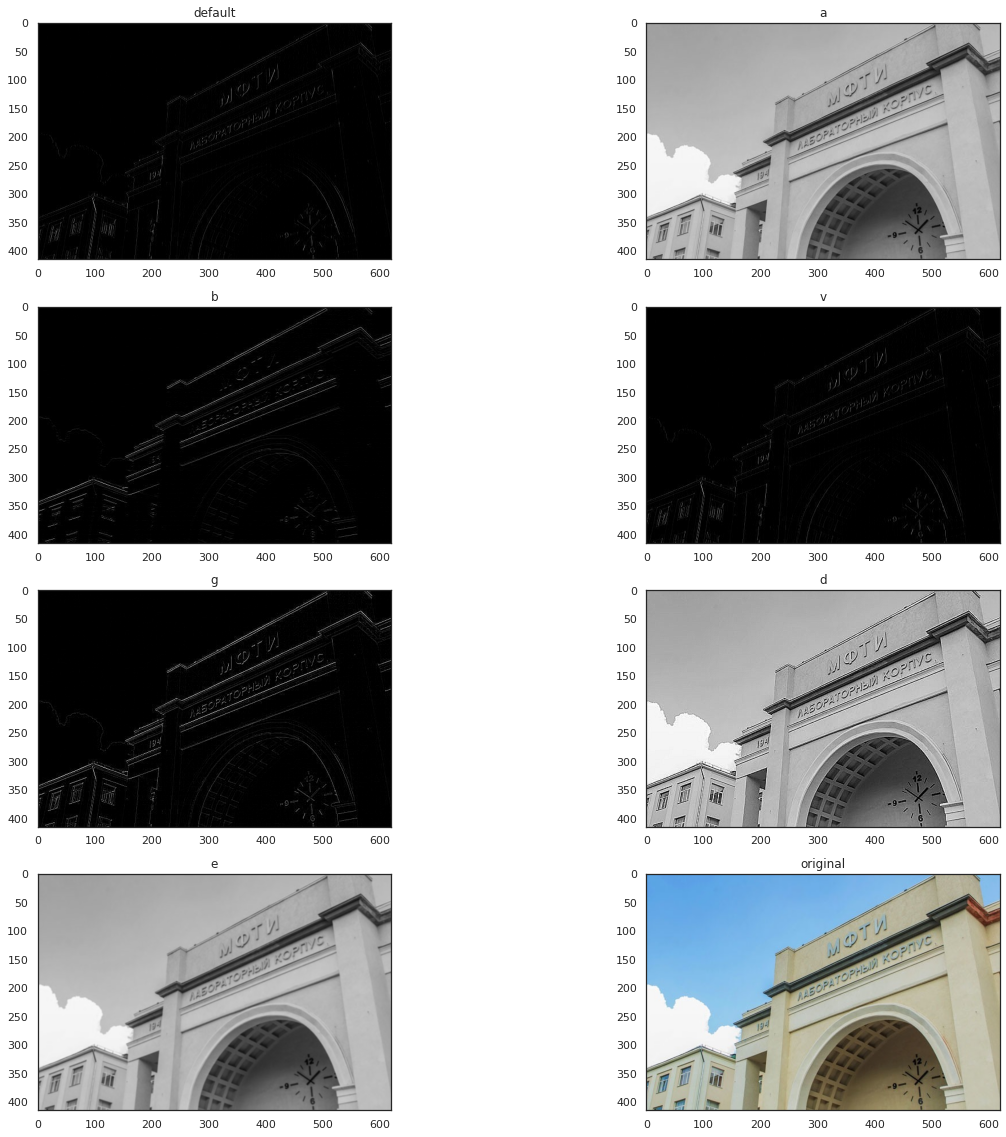

In [196]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size
fig, axes = plt.subplots(4, 2, figsize=(20, 20))
for i, var in enumerate(kernels):
    ker = torch.tensor(kernels[var]).reshape(1, 1, 3, 3).type(torch.float32).repeat(3, 3, 1, 1)
    result[var] = F.conv2d(img_t, ker)[0].permute(1, 2, 0).numpy() / 256 / 3 
    axes[i//2, i%2].set_title(var)
    axes[i//2, i%2].imshow(result[var])
axes[-1, -1].set_title('original')
axes[-1, -1].imshow(RGB_img)
plt.show()
None

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.
**Ответ:**
1) Размытие (е)

2) Увеличение резкости (д)

3) Тождественное преобразование (a)

4) Выделение вертикальных границ (в)

5) Выделение горизонтальных границ (б)

6) Выделение границ (г)



### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential). 

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [211]:
from torchsummary import summary

In [274]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.net = nn.Sequential(
        nn.Conv2d(1, 6, 3),
        nn.ReLU(),
        nn.MaxPool2d(2), #YOUR CODE
        nn.Conv2d(6, 16, 3),#YOUR CODE
        nn.ReLU(),
        nn.MaxPool2d(2),#YOUR CODE
        nn.Flatten(),
        # [128, 16, 5, 5]
        nn.Linear(16*5*5, 120),#YOUR CODE
        nn.ReLU(),
        nn.Linear(120, 84),#YOUR CODE
        nn.ReLU(),
        nn.Linear(84, 10),#YOUR CODE
        )
    def forward(self, x):       
        x = self.net(x)
        return x

In [243]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [244]:
print(model)

LeNet(
  (net): Sequential(
    (0): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=400, out_features=120, bias=True)
    (8): ReLU()
    (9): Linear(in_features=120, out_features=84, bias=True)
    (10): ReLU()
    (11): Linear(in_features=84, out_features=10, bias=True)
  )
)


Epoch: 1
Loader: train. Accuracy: 0.8691833333333333
Loader: valid. Accuracy: 0.9639
Epoch: 2
Loader: train. Accuracy: 0.9656666666666667
Loader: valid. Accuracy: 0.9746
Epoch: 3
Loader: train. Accuracy: 0.9761166666666666
Loader: valid. Accuracy: 0.9778
Epoch: 4
Loader: train. Accuracy: 0.9814333333333334
Loader: valid. Accuracy: 0.9824
Epoch: 5
Loader: train. Accuracy: 0.98495
Loader: valid. Accuracy: 0.9843
Epoch: 6
Loader: train. Accuracy: 0.9874666666666667
Loader: valid. Accuracy: 0.9859
Epoch: 7
Loader: train. Accuracy: 0.9895833333333334
Loader: valid. Accuracy: 0.986
Epoch: 8
Loader: train. Accuracy: 0.9912666666666666
Loader: valid. Accuracy: 0.9848
Epoch: 9
Loader: train. Accuracy: 0.9925666666666667
Loader: valid. Accuracy: 0.9847
Epoch: 10
Loader: train. Accuracy: 0.9936666666666667
Loader: valid. Accuracy: 0.985


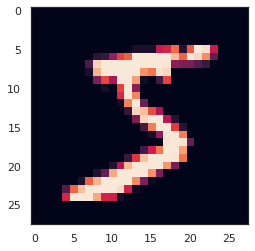

In [206]:
plt.imshow(train_dataloader.dataset.data[0])
None

### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [ ]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                model.train().to(device)
                optimizer.zero_grad()
                outp = model(x_batch.to(device))
                 # YOUR CODE. Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
            else:
                model.eval()
                with torch.no_grad():
                    outp = model.to(device)(x_batch.to(device))
                 # YOUR CODE. Set model to ``eval`` mode and calculate outputs
            preds = outp.argmax(-1)
            correct = (preds == y_batch.to(device)).sum()# YOUR CODE GOES HERE
            all = y_batch.size()[0]# YOUR CODE GOES HERE
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch.to(device))
                loss.backward()
                optimizer.step()
                # YOUR CODE. Calculate gradients and make a step of your optimizer
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

In [246]:
lenet_accuracy = accuracy["valid"]

In [250]:
lenet_accuracy[-1]

0.985

Сравним с предыдущем пунктом

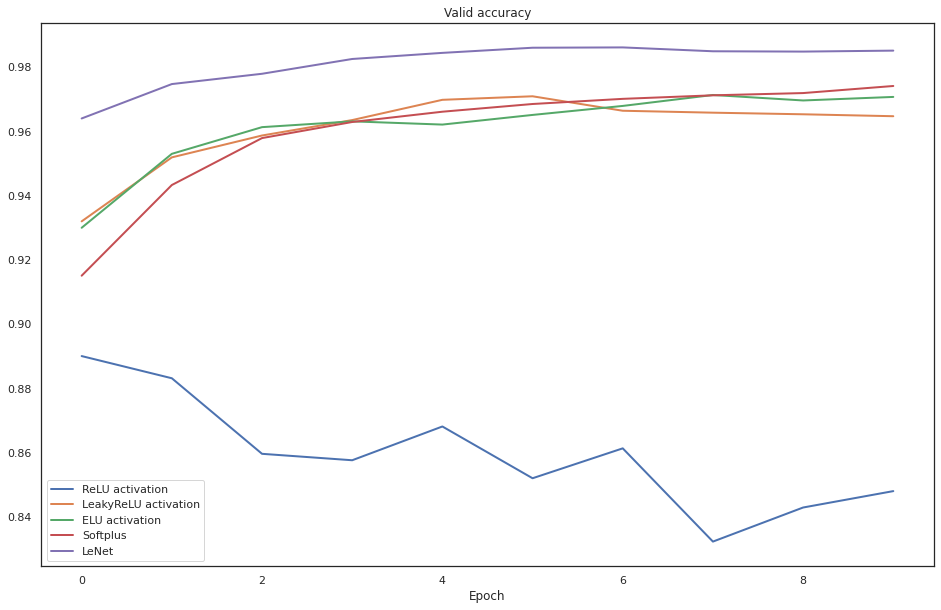

In [248]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), softplus_accuracy, label="Softplus", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:**
0.985